In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
pd.set_option("display.max_columns",None)
pd.set_option("display.float_format",lambda x: '%.5f' % x)

df_ = pd.read_excel("online_retail_II.xlsx",sheet_name="Year 2010-2011")
df_.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55000,17850.00000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75000,17850.00000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom


In [2]:
df = df_.copy()

In [3]:
df.dropna(inplace=True)
df = df[~df["Invoice"].str.contains("C",na=False)]
df = df[df["Quantity"]>0]
df = df[df["Price"]>0]

In [65]:
plt.style.use("dark_background")
def plot_boxplot_and_hist(data, variable):
    
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.50, 0.85)})
    
    # Boxplot
    axs[0].boxplot(data[variable], vert=False)
    axs[0].set_title(variable)
    
    # Histogram
    axs[1].hist(data[variable], color="orange", edgecolor="black",bins=20)
    
    plt.show()

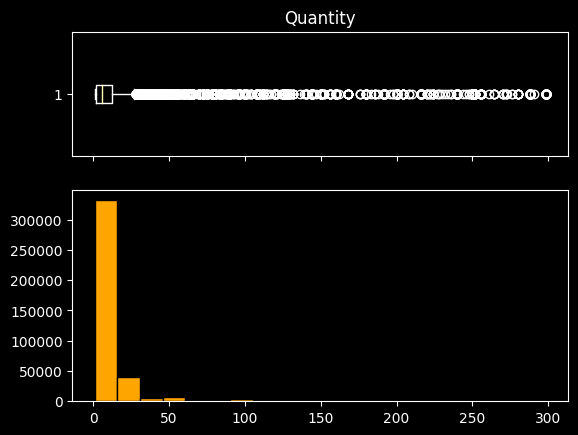

In [66]:
plot_boxplot_and_hist(df,"Quantity")

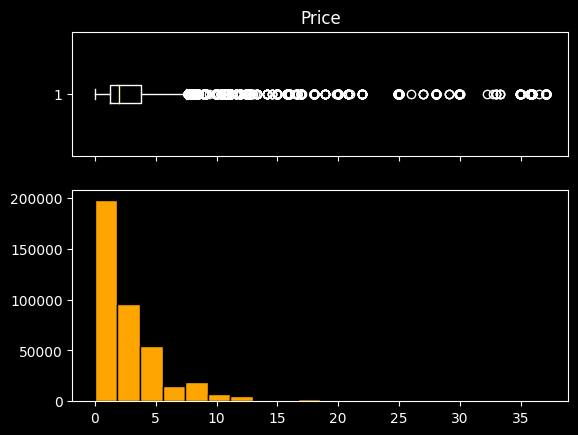

In [67]:
plot_boxplot_and_hist(df,"Price")

In [7]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,397885.00000,397885,397885.00000,397885.00000
mean,12.98821,2011-07-10 23:41:56.419316992,3.11653,15294.41688
min,1.00000,2010-12-01 08:26:00,0.00100,12346.00000
25%,2.00000,2011-04-07 11:12:00,1.25000,13969.00000
50%,6.00000,2011-07-31 14:39:00,1.95000,15159.00000
75%,12.00000,2011-10-20 14:33:00,3.75000,16795.00000
max,80995.00000,2011-12-09 12:50:00,8142.75000,18287.00000
std,179.33155,NaN,22.09786,1713.14442


In [8]:
def find_limits(df,variable):
    q1 = df[variable].quantile(0.01)
    q3 = df[variable].quantile(0.99)
    iqr = q3 - q1
    upper_limit = q3 + 1.5*iqr
    lower_limit = q1 - 1.5*iqr
    return lower_limit, upper_limit

In [9]:
lower_limit, upper_limit = find_limits(df,"Quantity")
lower_limit, upper_limit

(-177.5, 298.5)

In [10]:
df["Quantity"].clip(upper=upper_limit,inplace=True)

In [11]:
lower_limit, upper_limit = find_limits(df,"Price")
lower_limit, upper_limit

(-21.9, 37.06)

In [12]:
df["Price"].clip(upper=upper_limit,inplace=True)

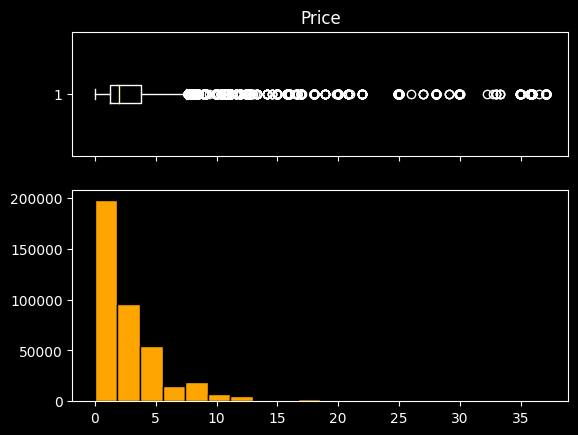

In [13]:
plot_boxplot_and_hist(df,"Price")

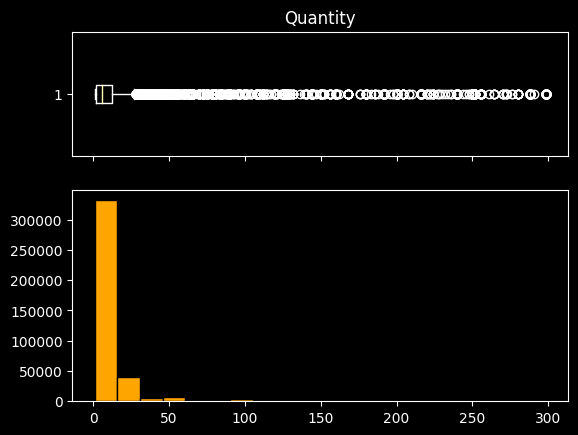

In [14]:
plot_boxplot_and_hist(df,"Quantity")

In [15]:
df[["Quantity","Price"]].describe()

,Quantity,Price
count,397885.00000,397885.00000
mean,11.83077,2.89349
std,25.52305,3.22718
min,1.00000,0.00100
25%,2.00000,1.25000
50%,6.00000,1.95000
75%,12.00000,3.75000
max,298.50000,37.06000


In [16]:
df["total_price"] = df["Quantity"] * df["Price"]
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,total_price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.00000,2010-12-01 08:26:00,2.55000,17850.00000,United Kingdom,15.30000
1,536365,71053,WHITE METAL LANTERN,6.00000,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom,20.34000
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.00000,2010-12-01 08:26:00,2.75000,17850.00000,United Kingdom,22.00000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.00000,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom,20.34000
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.00000,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom,20.34000


In [17]:
df.groupby("Invoice")["Customer ID"].count()

Invoice
536365     7
536366     2
536367    12
536368     4
536369     1
          ..
581583     2
581584     2
581585    21
581586     4
581587    16
Name: Customer ID, Length: 18532, dtype: int64

In [18]:
df.groupby("Customer ID")["Invoice"].count()

Customer ID
12346.00000      1
12347.00000    182
12348.00000     31
12349.00000     73
12350.00000     17
              ... 
18280.00000     10
18281.00000      7
18282.00000     12
18283.00000    756
18287.00000     70
Name: Invoice, Length: 4338, dtype: int64

In [19]:
df["InvoiceDate"].max()

Timestamp('2011-12-09 12:50:00')

In [20]:
today_date = dt.datetime(2011,12,11)

In [21]:
# recency: kullanıcının ilk satın alması ile son satın alması arasındaki fark . Haftalık (kullanıcı özelinde)
# T : müşterinin yaşı. Haftalık.(ilk satın alma ile analiz tarihi arasındaki süre)
# frequency: tekrar eden toplam satın alma sayısı (frequency >1)
# monetary: satın alma başına ortalama kazanç

In [22]:
cltv_df = df.groupby("Customer ID").agg({"InvoiceDate":[lambda date: (date.max() - date.min()).days,
                                                        lambda date: (today_date-date.min()).days],
                                         "Invoice":lambda x:x.nunique(),
                                         "total_price": lambda x:x.sum()})

cltv_df

InvoiceDate             Invoice total_price
             <lambda_0> <lambda_1> <lambda>    <lambda>
Customer ID                                            
12346.00000           0        326        1   310.44000
12347.00000         365        368        7  4310.00000
12348.00000         282        359        4  1770.78000
12349.00000           0         19        1  1491.72000
12350.00000           0        311        1   331.46000
...                 ...        ...      ...         ...
18280.00000           0        278        1   180.60000
18281.00000           0        181        1    80.82000
18282.00000         118        127        2   178.05000
18283.00000         333        338       16  2094.88000
18287.00000         158        202        3  1837.28000

[4338 rows x 4 columns]

In [23]:
cltv_df.columns = cltv_df.columns.droplevel(0)

In [24]:
cltv_df.columns = ["recency","T","frequency","monetary"]
cltv_df

,recency,T,frequency,monetary
Customer ID,,,,
12346.00000,0,326,1,310.44000
12347.00000,365,368,7,4310.00000
12348.00000,282,359,4,1770.78000
12349.00000,0,19,1,1491.72000
12350.00000,0,311,1,331.46000
...,...,...,...,...
18280.00000,0,278,1,180.60000
18281.00000,0,181,1,80.82000
18282.00000,118,127,2,178.05000


In [25]:
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

In [26]:
cltv_df.describe()

,recency,T,frequency,monetary
count,4338.00000,4338.00000,4338.00000,4338.00000
mean,130.44859,223.83103,4.27201,364.11847
std,132.03955,117.85457,7.69800,367.25822
min,0.00000,1.00000,1.00000,3.45000
25%,0.00000,113.00000,1.00000,176.85125
50%,92.50000,249.00000,2.00000,288.22545
75%,251.75000,327.00000,5.00000,422.02937
max,373.00000,374.00000,209.00000,6207.67000


In [27]:
cltv_df = cltv_df[cltv_df["frequency"]>1]

In [28]:
cltv_df.describe()

,recency,T,frequency,monetary
count,2845.00000,2845.00000,2845.00000,2845.00000
mean,198.90545,258.78418,5.98910,372.17356
std,113.86696,102.99092,9.04425,349.30119
min,0.00000,3.00000,2.00000,3.45000
25%,98.00000,192.00000,2.00000,191.07333
50%,207.00000,283.00000,4.00000,300.48731
75%,299.00000,359.00000,6.00000,436.87000
max,373.00000,374.00000,209.00000,5724.30262


In [29]:
cltv_df["recency"] =cltv_df["recency"] / 7 #weekly
cltv_df["T"] = cltv_df["T"] / 7

In [30]:
cltv_df.describe()

,recency,T,frequency,monetary
count,2845.00000,2845.00000,2845.00000,2845.00000
mean,28.41506,36.96917,5.98910,372.17356
std,16.26671,14.71299,9.04425,349.30119
min,0.00000,0.42857,2.00000,3.45000
25%,14.00000,27.42857,2.00000,191.07333
50%,29.57143,40.42857,4.00000,300.48731
75%,42.71429,51.28571,6.00000,436.87000
max,53.28571,53.42857,209.00000,5724.30262


In [31]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df["frequency"],
        cltv_df["recency"],
        cltv_df["T"])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.41, b: 2.49, r: 2.18>

In [32]:
bgf.conditional_expected_number_of_purchases_up_to_time(1,cltv_df["frequency"],
                                                            cltv_df["recency"],
                                                            cltv_df["T"]).sort_values(ascending =False)

Customer ID
12748.00000   3.24953
14911.00000   3.12642
17841.00000   1.94015
13089.00000   1.53742
14606.00000   1.46390
                ...  
13093.00000   0.00085
15107.00000   0.00056
16725.00000   0.00038
15332.00000   0.00013
17850.00000   0.00000
Length: 2845, dtype: float64

In [33]:
bgf.predict(1,cltv_df["frequency"],
            cltv_df["recency"],
            cltv_df["T"]).sort_values(ascending =False)

Customer ID
12748.00000   3.24953
14911.00000   3.12642
17841.00000   1.94015
13089.00000   1.53742
14606.00000   1.46390
                ...  
13093.00000   0.00085
15107.00000   0.00056
16725.00000   0.00038
15332.00000   0.00013
17850.00000   0.00000
Length: 2845, dtype: float64

In [34]:
cltv_df["expected_purch_1_week"] = bgf.predict(1,cltv_df["frequency"],
            cltv_df["recency"],
            cltv_df["T"])

In [35]:
df.groupby("Customer ID").agg({"Invoice":lambda x:x.nunique(),
                               "total_price":"sum"})

,Invoice,total_price
Customer ID,,
12346.00000,1,310.44000
12347.00000,7,4310.00000
12348.00000,4,1770.78000
12349.00000,1,1491.72000
12350.00000,1,331.46000
...,...,...
18280.00000,1,180.60000
18281.00000,1,80.82000
18282.00000,2,178.05000


In [36]:
cltv_df

,recency,T,frequency,monetary,expected_purch_1_week
Customer ID,,,,,
12347.00000,52.14286,52.57143,7,615.71429,0.14128
12348.00000,40.28571,51.28571,4,442.69500,0.09196
12352.00000,37.14286,42.42857,8,219.54250,0.18239
12356.00000,43.14286,46.57143,3,937.14333,0.08616
12358.00000,21.28571,21.57143,2,575.21000,0.12226
...,...,...,...,...,...
18272.00000,34.85714,35.28571,6,513.09667,0.17206
18273.00000,36.42857,36.85714,3,68.00000,0.10434
18282.00000,16.85714,18.14286,2,89.02500,0.13566


In [37]:
cltv_df["expected_purch_1_month"] = bgf.predict(4,cltv_df["frequency"],
            cltv_df["recency"],
            cltv_df["T"])

cltv_df

,recency,T,frequency,monetary,expected_purch_1_week,expected_purch_1_month
Customer ID,,,,,,
12347.00000,52.14286,52.57143,7,615.71429,0.14128,0.56351
12348.00000,40.28571,51.28571,4,442.69500,0.09196,0.36676
12352.00000,37.14286,42.42857,8,219.54250,0.18239,0.72710
12356.00000,43.14286,46.57143,3,937.14333,0.08616,0.34352
12358.00000,21.28571,21.57143,2,575.21000,0.12226,0.48623
...,...,...,...,...,...,...
18272.00000,34.85714,35.28571,6,513.09667,0.17206,0.68556
18273.00000,36.42857,36.85714,3,68.00000,0.10434,0.41574
18282.00000,16.85714,18.14286,2,89.02500,0.13566,0.53921


In [38]:
bgf.predict(4,cltv_df["frequency"],
            cltv_df["recency"],
            cltv_df["T"]).sum()

1776.893473220294

In [39]:
cltv_df2 = cltv_df.copy()

In [68]:
cltv_df2["frequency"] = cltv_df2["frequency"] -1

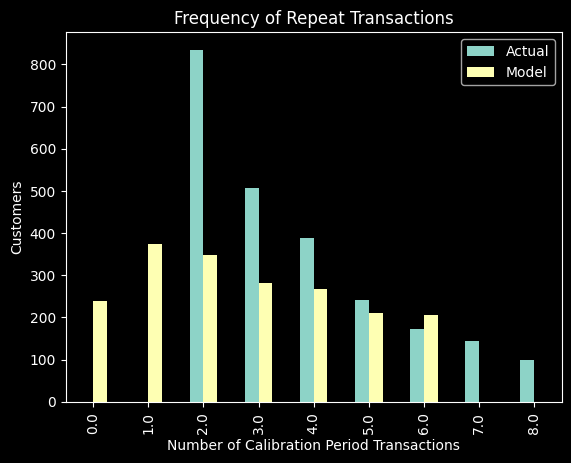

In [69]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df["frequency"],
        cltv_df["recency"],
        cltv_df["T"])
plot_period_transactions(bgf)
plt.show()

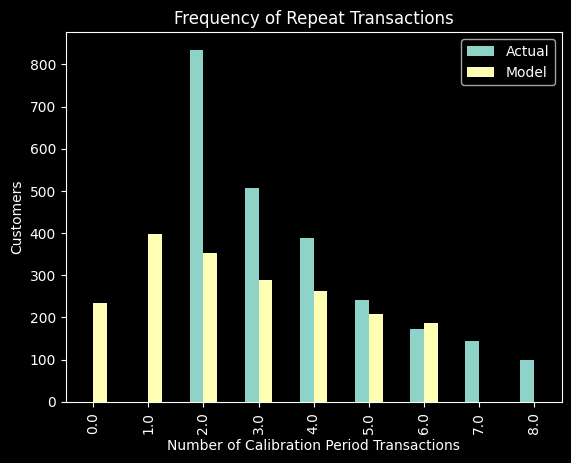

In [73]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df["frequency"],
        cltv_df["recency"],
        cltv_df["T"])
plot_period_transactions(bgf)
plt.show()

In [43]:
cltv_df2

,recency,T,frequency,monetary,expected_purch_1_week,expected_purch_1_month
Customer ID,,,,,,
12347.00000,52.14286,52.57143,6,615.71429,0.14128,0.56351
12348.00000,40.28571,51.28571,3,442.69500,0.09196,0.36676
12352.00000,37.14286,42.42857,7,219.54250,0.18239,0.72710
12356.00000,43.14286,46.57143,2,937.14333,0.08616,0.34352
12358.00000,21.28571,21.57143,1,575.21000,0.12226,0.48623
...,...,...,...,...,...,...
18272.00000,34.85714,35.28571,5,513.09667,0.17206,0.68556
18273.00000,36.42857,36.85714,2,68.00000,0.10434,0.41574
18282.00000,16.85714,18.14286,1,89.02500,0.13566,0.53921


In [44]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df["frequency"],cltv_df["monetary"])

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.79, q: 0.34, v: 3.73>

In [45]:
ggf.conditional_expected_average_profit(cltv_df["frequency"],cltv_df["monetary"])

Customer ID
12347.00000   631.91230
12348.00000   463.74596
12352.00000   224.88677
12356.00000   995.99892
12358.00000   631.90217
                 ...   
18272.00000   529.01845
18273.00000    73.49423
18282.00000    99.52493
18283.00000   132.60123
18287.00000   651.34616
Length: 2845, dtype: float64

In [46]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df["frequency"],cltv_df["monetary"])

In [47]:
cltv_df

,recency,T,frequency,monetary,expected_purch_1_week,expected_purch_1_month,expected_average_profit
Customer ID,,,,,,,
12347.00000,52.14286,52.57143,7,615.71429,0.14128,0.56351,631.91230
12348.00000,40.28571,51.28571,4,442.69500,0.09196,0.36676,463.74596
12352.00000,37.14286,42.42857,8,219.54250,0.18239,0.72710,224.88677
12356.00000,43.14286,46.57143,3,937.14333,0.08616,0.34352,995.99892
12358.00000,21.28571,21.57143,2,575.21000,0.12226,0.48623,631.90217
...,...,...,...,...,...,...,...
18272.00000,34.85714,35.28571,6,513.09667,0.17206,0.68556,529.01845
18273.00000,36.42857,36.85714,3,68.00000,0.10434,0.41574,73.49423
18282.00000,16.85714,18.14286,2,89.02500,0.13566,0.53921,99.52493


In [48]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df["frequency"],
                                   cltv_df["recency"],
                                   cltv_df["T"],
                                   cltv_df["monetary"],
                                   time=3, #3 aylık
                                   freq="W", # T nin frekans bilgisi,
                                   discount_rate=0.01)

In [49]:
cltv

Customer ID
12347.00000   1128.44766
12348.00000    538.80895
12352.00000    517.50002
12356.00000   1083.09025
12358.00000    966.67270
                 ...    
18272.00000   1146.20565
18273.00000     96.56482
18282.00000    168.59460
18283.00000    505.51169
18287.00000    988.30285
Name: clv, Length: 2845, dtype: float64

In [50]:
cltv = cltv.reset_index()
cltv

,Customer ID,clv
0,12347.00000,1128.44766
1,12348.00000,538.80895
2,12352.00000,517.50002
3,12356.00000,1083.09025
4,12358.00000,966.67270
...,...,...
2840,18272.00000,1146.20565
2841,18273.00000,96.56482
2842,18282.00000,168.59460
2843,18283.00000,505.51169


In [53]:
cltv_df

,recency,T,frequency,monetary,expected_purch_1_week,expected_purch_1_month,expected_average_profit
Customer ID,,,,,,,
12347.00000,52.14286,52.57143,7,615.71429,0.14128,0.56351,631.91230
12348.00000,40.28571,51.28571,4,442.69500,0.09196,0.36676,463.74596
12352.00000,37.14286,42.42857,8,219.54250,0.18239,0.72710,224.88677
12356.00000,43.14286,46.57143,3,937.14333,0.08616,0.34352,995.99892
12358.00000,21.28571,21.57143,2,575.21000,0.12226,0.48623,631.90217
...,...,...,...,...,...,...,...
18272.00000,34.85714,35.28571,6,513.09667,0.17206,0.68556,529.01845
18273.00000,36.42857,36.85714,3,68.00000,0.10434,0.41574,73.49423
18282.00000,16.85714,18.14286,2,89.02500,0.13566,0.53921,99.52493


In [56]:
cltv_final = pd.merge(cltv_df,cltv,left_index=True,right_on="Customer ID")
cltv_final

,recency,T,frequency,monetary,expected_purch_1_week,expected_purch_1_month,expected_average_profit,Customer ID,clv
0,52.14286,52.57143,7,615.71429,0.14128,0.56351,631.91230,12347.00000,1128.44766
1,40.28571,51.28571,4,442.69500,0.09196,0.36676,463.74596,12348.00000,538.80895
2,37.14286,42.42857,8,219.54250,0.18239,0.72710,224.88677,12352.00000,517.50002
3,43.14286,46.57143,3,937.14333,0.08616,0.34352,995.99892,12356.00000,1083.09025
4,21.28571,21.57143,2,575.21000,0.12226,0.48623,631.90217,12358.00000,966.67270
...,...,...,...,...,...,...,...,...,...
2840,34.85714,35.28571,6,513.09667,0.17206,0.68556,529.01845,18272.00000,1146.20565
2841,36.42857,36.85714,3,68.00000,0.10434,0.41574,73.49423,18273.00000,96.56482
2842,16.85714,18.14286,2,89.02500,0.13566,0.53921,99.52493,18282.00000,168.59460
2843,47.57143,48.28571,16,130.93000,0.30174,1.20336,132.60123,18283.00000,505.51169


In [57]:
cltv_final.sort_values(by="clv",ascending=False)

,recency,T,frequency,monetary,expected_purch_1_week,expected_purch_1_month,expected_average_profit,Customer ID,clv
1122,50.42857,50.71429,73,3646.07568,1.20636,4.81192,3654.81481,14646.00000,55741.08447
2761,52.28571,52.57143,60,3859.73908,0.96854,3.86360,3870.99693,18102.00000,47412.58011
843,13.85714,14.57143,17,3163.58824,0.72868,2.89554,3196.43606,14096.00000,29061.66139
36,44.71429,48.28571,21,5724.30262,0.37960,1.51390,5772.17817,12415.00000,27685.10001
1257,53.14286,53.42857,201,691.71010,3.12642,12.47220,692.32637,14911.00000,27377.41152
...,...,...,...,...,...,...,...,...,...
2682,7.71429,52.14286,5,62.20200,0.00110,0.00438,65.21106,17912.00000,0.90479
1447,0.42857,52.85714,4,415.26500,0.00013,0.00051,435.07200,15332.00000,0.70070
2100,9.85714,53.14286,7,111.57429,0.00038,0.00151,114.95683,16725.00000,0.55042
1346,8.71429,53.28571,6,53.25000,0.00056,0.00224,55.47599,15107.00000,0.39453


In [60]:
cltv.sort_values(by="clv",ascending=False).head(10)

,Customer ID,clv
1122,14646.00000,55741.08447
2761,18102.00000,47412.58011
843,14096.00000,29061.66139
36,12415.00000,27685.10001
1257,14911.00000,27377.41152
2458,17450.00000,27166.06434
874,14156.00000,23424.40318
2487,17511.00000,18986.61234
2075,16684.00000,13440.41309
650,13694.00000,12966.13470


In [61]:
bgf.conditional_expected_number_of_purchases_up_to_time(1,cltv_df["frequency"],
                                                            cltv_df["recency"],
                                                            cltv_df["T"]).sort_values(ascending =False)

Customer ID
12748.00000   3.24953
14911.00000   3.12642
17841.00000   1.94015
13089.00000   1.53742
14606.00000   1.46390
                ...  
13093.00000   0.00085
15107.00000   0.00056
16725.00000   0.00038
15332.00000   0.00013
17850.00000   0.00000
Length: 2845, dtype: float64